In [18]:
#@title 0) Install & Imports
!pip -q install hypernetx==2.3.4 networkx==3.3 ipywidgets==8.1.3

import numpy as np
import pandas as pd
import networkx as nx
import hypernetx as hnx
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Set

from IPython.display import display, clear_output
import ipywidgets as widgets

np.set_printoptions(precision=4, suppress=True)
RNG = np.random.default_rng(7)


In [19]:
#@title 1) Data + Hypergraphs (traits→characters, hyperfactors→traits)

# Characters & Traits
characters = [
    "Harry Potter", "Hermione Granger", "Darth Vader", "Luke Skywalker",
    "Iron Man", "Captain America", "Sherlock Holmes", "Daenerys Targaryen"
]
traits = [
    "is_wizard", "is_female", "has_glasses", "uses_sword",
    "from_marvel", "wears_armor", "from_star_wars", "from_westeros",
    "is_detective", "has_dragon"
]
N, M = len(characters), len(traits)

# Base P(yes | character, trait), lightly smoothed
P_yes = np.full((N, M), 0.05, dtype=float)
def setp(c, t, p=1.0): P_yes[characters.index(c), traits.index(t)] = p

# Wizarding world
for c in ["Harry Potter", "Hermione Granger"]: setp(c, "is_wizard", 1.0)
setp("Harry Potter", "has_glasses", 0.95)
setp("Hermione Granger", "is_female", 1.0)

# Star Wars
for c in ["Darth Vader", "Luke Skywalker"]:
    setp(c, "from_star_wars", 1.0)
    setp(c, "uses_sword", 0.95)
setp("Darth Vader", "wears_armor", 0.9)

# Marvel
for c in ["Iron Man", "Captain America"]: setp(c, "from_marvel", 1.0)
setp("Iron Man", "wears_armor", 0.98)
setp("Captain America", "uses_sword", 0.15)

# Westeros & detective
setp("Daenerys Targaryen", "from_westeros", 1.0)
setp("Daenerys Targaryen", "is_female", 1.0)
setp("Daenerys Targaryen", "has_dragon", 0.98)
setp("Sherlock Holmes", "is_detective", 0.98)

# Priors (you can change to degree-based later)
priors = np.full(N, 1.0 / N)

# ---------- Build hypergraph 1: trait hyperedges over character nodes ----------
YES_THRESH = 0.6  # include c in trait edge if P_yes[c,trait] >= 0.6
trait_edges = {}
for j, t in enumerate(traits):
    members = [characters[i] for i in range(N) if P_yes[i, j] >= YES_THRESH]
    if members:
        trait_edges[t] = set(members)
H_traits = hnx.Hypergraph(trait_edges)

# (optional) degree-based priors from H_traits
# char_deg = np.array([H_traits.degree(c) for c in characters], dtype=float)
# if char_deg.sum() > 0: priors = char_deg / char_deg.sum()

# ---------- Build hypergraph 2: hyperfactors as hyperedges over TRAIT nodes ----------
# Each hyperfactor edge connects a set of trait nodes; we store a per-character log-bonus vector in hf_bonus.

def trait_idxs(names: Tuple[str, ...]) -> Tuple[int, ...]:
    return tuple(traits.index(n) for n in names)

# define hyperfactors as (edge_name, trait_name_tuple, per-character log-bonus dict)
raw_hf = [
    ("HF_wizard_glasses", ("is_wizard","has_glasses"), {"Harry Potter": 1.4}),
    ("HF_wizard_female", ("is_wizard","is_female"), {"Hermione Granger": 1.2}),
    ("HF_sw_armor", ("from_star_wars","wears_armor"), {"Darth Vader": 1.3}),
    ("HF_marvel_armor", ("from_marvel","wears_armor"), {"Iron Man": 1.2}),
    ("HF_westeros_dragon", ("from_westeros","has_dragon"), {"Daenerys Targaryen": 1.5}),
]

# hypergraph edge dict: name -> set of TRAIT nodes
hf_edges = {name: set(traits_tup) for name, traits_tup, _ in raw_hf}
H_hf = hnx.Hypergraph(hf_edges)

# bonus lookup: edge_name -> np.array per character
hf_bonus: Dict[str, np.ndarray] = {}
for name, traits_tup, boost_dict in raw_hf:
    vec = np.zeros(N)
    for cname, v in boost_dict.items():
        vec[characters.index(cname)] = v
    hf_bonus[name] = vec

print("Built H_traits (traits→characters) and H_hf (hyperfactors→traits).")


Built H_traits (traits→characters) and H_hf (hyperfactors→traits).


Trait hyperedges → character nodes (thresholded memberships):
  is_wizard: ['Harry Potter', 'Hermione Granger']
  is_female: ['Daenerys Targaryen', 'Hermione Granger']
  has_glasses: ['Harry Potter']
  uses_sword: ['Darth Vader', 'Luke Skywalker']
  from_marvel: ['Captain America', 'Iron Man']
  wears_armor: ['Darth Vader', 'Iron Man']
  from_star_wars: ['Darth Vader', 'Luke Skywalker']
  from_westeros: ['Daenerys Targaryen']
  is_detective: ['Sherlock Holmes']
  has_dragon: ['Daenerys Targaryen']

Hyperfactor edges → trait nodes:
  HF_wizard_glasses: ['has_glasses', 'is_wizard']
  HF_wizard_female: ['is_female', 'is_wizard']
  HF_sw_armor: ['from_star_wars', 'wears_armor']
  HF_marvel_armor: ['from_marvel', 'wears_armor']
  HF_westeros_dragon: ['from_westeros', 'has_dragon']


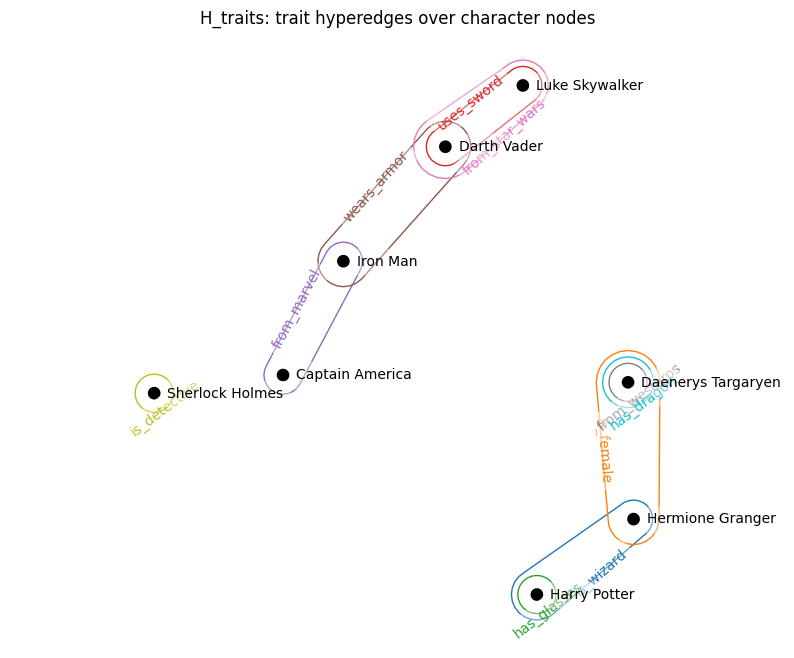

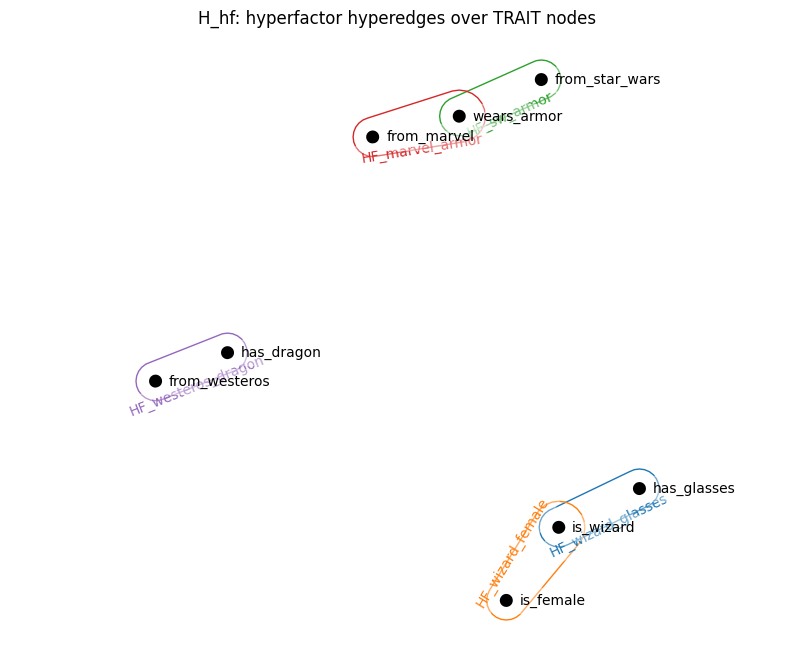

In [22]:
#@title 2) Visualize hypergraphs (optional)
print("Trait hyperedges → character nodes (thresholded memberships):")
# Modify to iterate using standard edge object access
for edge_name in H_traits.edges:
    print(f"  {edge_name}: {sorted(list(H_traits.edges[edge_name]))}")

print("\nHyperfactor edges → trait nodes:")
# Modify to iterate using standard edge object access
for edge_name in H_hf.edges:
    print(f"  {edge_name}: {sorted(list(H_hf.edges[edge_name]))}")

import matplotlib.pyplot as plt

# Draw H_traits
plt.figure(figsize=(10, 8))
hnx.draw(H_traits, with_node_labels=True, with_edge_labels=True)
plt.title("H_traits: trait hyperedges over character nodes")
plt.show()

# Draw H_hf
plt.figure(figsize=(10, 8))
hnx.draw(H_hf, with_node_labels=True, with_edge_labels=True)
plt.title("H_hf: hyperfactor hyperedges over TRAIT nodes")
plt.show()

In [26]:
#@title 3) Full Hypergraph Inference Engine (Bayes + MI, hyperedges read via H_hf)
@dataclass
class GameState:
    posterior: np.ndarray
    answered: Dict[int, str]

class HypergraphBayesHG:
    def __init__(self,
                 priors: np.ndarray,
                 P_yes: np.ndarray,
                 H_hf: hnx.Hypergraph,
                 hf_bonus: Dict[str, np.ndarray],
                 alpha: float = 0.10,
                 unknown_weight: float = 0.0):
        self.N, self.M = P_yes.shape
        self.priors = priors / priors.sum()
        self.P_yes = P_yes.copy()
        self.H_hf = H_hf
        self.hf_bonus = hf_bonus
        self.alpha = float(alpha)
        self.unknown_weight = float(unknown_weight)

        self.trait_to_idx = {t: i for i, t in enumerate(traits)}
        self.idx_to_trait = {i: t for i, t in enumerate(traits)}

    # noisy yes-likelihood
    def p_yes(self, c: int, q: int) -> float:
        base = self.P_yes[c, q]
        return self.alpha + (1 - 2*self.alpha) * base

    @staticmethod
    def _normalize(v: np.ndarray) -> np.ndarray:
        s = v.sum()
        return v / s if s > 0 else np.full_like(v, 1.0 / len(v))

    @staticmethod
    def _entropy(p: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        return float(-(p * np.log(p)).sum())

    def _active_hf_bonus(self, answers: Dict[int, str]) -> np.ndarray:
        """Sum log-bonus vectors for hyperfactor edges whose trait set is all answered 'yes'."""
        bonus = np.zeros(self.N)
        # Iterate directly over self.H_hf.edges which is a HypergraphView
        for e_name in self.H_hf.edges:
            trait_names = list(self.H_hf.edges[e_name])
            if all(answers.get(self.trait_to_idx[t], None) == "yes" for t in trait_names):
                if e_name in self.hf_bonus:
                    bonus += self.hf_bonus[e_name]
        return bonus

    def posterior_from(self, answers: Dict[int, str]) -> np.ndarray:
        logp = np.log(np.clip(self.priors, 1e-12, 1.0))
        for q, a in answers.items():
            py = np.array([self.p_yes(c, q) for c in range(self.N)])
            if a == "yes":
                logp += np.log(np.clip(py, 1e-12, 1.0))
            elif a == "no":
                logp += np.log(np.clip(1 - py, 1e-12, 1.0))

        logp += self._active_hf_bonus(answers)

        p = np.exp(logp - logp.max())
        p = self._normalize(p)
        if any(a == "unknown" for a in answers.values()) and self.unknown_weight > 0:
            p = (1 - self.unknown_weight) * p + self.unknown_weight * self.priors
            p = self._normalize(p)
        return p

    def update(self, state: GameState, q: int, a: str) -> GameState:
        new_ans = dict(state.answered)
        new_ans[q] = a
        return GameState(self.posterior_from(new_ans), new_ans)

    def info_gain(self, state: GameState, q: int) -> float:
        if q in state.answered: return -1.0
        p_curr = state.posterior
        H_curr = self._entropy(p_curr)
        py = np.array([self.p_yes(c, q) for c in range(self.N)])
        p_yes = float((p_curr * py).sum())
        post_yes = self.posterior_from({**state.answered, q: "yes"})
        post_no  = self.posterior_from({**state.answered, q: "no"})
        E_H = p_yes * self._entropy(post_yes) + (1 - p_yes) * self._entropy(post_no)
        return H_curr - E_H

    def choose_question(self, state: GameState, asked: Set[int]) -> int:
        candidates = [q for q in range(self.M) if q not in asked]
        if not candidates: return -1
        scores = [(q, self.info_gain(state, q)) for q in candidates]
        return max(scores, key=lambda x: x[1])[0]

    def should_guess(self, state: GameState,
                     tau: float = 0.93, margin: float = 0.35, min_questions: int = 4) -> bool:
        if len(state.answered) < min_questions: return False
        p = state.posterior
        top2 = np.sort(p)[-2:]
        return (p.max() >= tau) or (top2[-1] - top2[-2] >= margin) or (self._entropy(p) < 0.20)

    def topk(self, state: GameState, k=5):
        idx = np.argsort(-state.posterior)[:k]
        return [(characters[i], float(state.posterior[i])) for i in idx]

In [24]:
#@title 4) RL Thompson Sampling wrapper
class TSBandit:
    def __init__(self, M: int):
        self.a = np.ones(M)
        self.b = np.ones(M)
    def sample_weights(self): return RNG.beta(self.a, self.b)
    def update(self, asked: List[int], success: bool):
        for q in asked:
            if success: self.a[q] += 1
            else:       self.b[q] += 1

class HypergraphBayesHG_RL(HypergraphBayesHG):
    def __init__(self, *args, bandit: Optional[TSBandit] = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.bandit = bandit
    def choose_question(self, state: GameState, asked: Set[int]) -> int:
        base = np.array([self.info_gain(state, q) if q not in asked else -1.0
                         for q in range(self.M)])
        if self.bandit is None:
            q = int(np.argmax(base)); return q if base[q] >= 0 else -1
        w = self.bandit.sample_weights()
        score = base * w
        q = int(np.argmax(score)); return q if score[q] >= 0 else -1


In [29]:
#@title 6) Game helpers (simulation & eval)

# Define the simulate_answer function
def simulate_answer(true_char_idx: int, q: int, model: HypergraphBayesHG) -> str:
    """Simulates an answer based on the true character's trait probability."""
    prob_yes = model.p_yes(true_char_idx, q)
    # Simulate a noisy answer based on the probability
    if RNG.random() < prob_yes:
        return "yes"
    else:
        return "no"

def play_once(model: HypergraphBayesHG, true_char_name: str,
              max_steps=10, tau=0.93, margin=0.35, min_questions=4, verbose=True):
    true_idx = characters.index(true_char_name)
    state = GameState(model.priors.copy(), {})
    asked: Set[int] = set()
    order: List[int] = []

    for step in range(1, max_steps+1):
        q = model.choose_question(state, asked)
        if q == -1: break
        asked.add(q); order.append(q)

        # Simulated user (for testing)
        ans = simulate_answer(true_idx, q, model)
        state = model.update(state, q, ans)

        if verbose:
            print(f"Q{step}: {traits[q]} -> {ans} | top3={model.topk(state,3)}")

        if model.should_guess(state, tau=tau, margin=margin, min_questions=min_questions):
            break

    guess = int(state.posterior.argmax())
    return (characters[guess], guess == true_idx, step, order, state)

# sanity test
# Need to instantiate the model before using it
model = HypergraphBayesHG(priors, P_yes, H_hf, hf_bonus)
g, ok, st, _, _ = play_once(model, "Harry Potter", verbose=True)
print("Final guess:", g, "| Correct:", ok, "| Steps:", st)

def evaluate(model: HypergraphBayesHG, rounds=5, max_steps=10):
    wins, steps = [], []
    for cname in characters:
        for _ in range(rounds):
            guess, ok, s, *_ = play_once(model, cname, max_steps=max_steps, verbose=False)
            wins.append(int(ok)); steps.append(s)
    print(f"Win-rate: {np.mean(wins)*100:.1f}% | Avg steps: {np.mean(steps):.2f} over {len(wins)} games")

evaluate(model, rounds=3, max_steps=10)

Q1: is_wizard -> yes | top3=[('Harry Potter', 0.3409090909090909), ('Hermione Granger', 0.3409090909090909), ('Darth Vader', 0.053030303030303046)]
Q2: is_female -> no | top3=[('Harry Potter', 0.522972972972973), ('Darth Vader', 0.08135135135135137), ('Luke Skywalker', 0.08135135135135137)]
Q3: has_glasses -> yes | top3=[('Harry Potter', 0.9646765768606224), ('Darth Vader', 0.006023994541049694), ('Luke Skywalker', 0.006023994541049694)]
Q4: from_marvel -> no | top3=[('Harry Potter', 0.9750580788456717), ('Darth Vader', 0.006088822601340486), ('Luke Skywalker', 0.006088822601340486)]
Final guess: Harry Potter | Correct: True | Steps: 4
Win-rate: 62.5% | Avg steps: 4.67 over 24 games


In [30]:
#@title 7) Interactive play (uses the full hypergraph model)
def run_session(model: HypergraphBayesHG,
                max_steps=10, tau=0.94, margin=0.4, min_questions=5):
    state = GameState(model.priors.copy(), {})
    asked: Set[int] = set()
    last_q = None
    step = 1

    print("🤔 Think of a character from this list:\n")
    for c in characters: print(" •", c)
    print("\nAnswer the questions below 👇\n")

    out = widgets.Output()
    btn_yes = widgets.Button(description="Yes", button_style="success")
    btn_no = widgets.Button(description="No", button_style="danger")
    btn_unknown = widgets.Button(description="Unknown")
    buttons = widgets.HBox([btn_yes, btn_no, btn_unknown])
    display(out, buttons)

    def maybe_guess():
        if model.should_guess(state, tau=tau, margin=margin, min_questions=min_questions) or step > max_steps:
            with out:
                clear_output(wait=True)
                guess_idx = int(state.posterior.argmax())
                guess = characters[guess_idx]
                print(f"🤖 I think it's **{guess}** (p≈{state.posterior[guess_idx]:.2f})")
                print("Top-5:", model.topk(state, 5))
            buttons.close()
            return True
        return False

    def ask():
        nonlocal last_q, step
        if maybe_guess(): return
        q = model.choose_question(state, asked)
        if q == -1:
            maybe_guess(); return
        asked.add(q); last_q = q
        with out:
            clear_output(wait=True)
            print(f"Q{step}: {traits[q]} ?")
            print("Top-3 so far:", model.topk(state, 3))
        step += 1

    def on_click(ans):
        nonlocal state
        if last_q is None: return
        state = model.update(state, last_q, ans)
        ask()

    btn_yes.on_click(lambda _: on_click("yes"))
    btn_no.on_click(lambda _: on_click("no"))
    btn_unknown.on_click(lambda _: on_click("unknown"))
    ask()

# ▶️ run the UI
run_session(model, max_steps=10, tau=0.94, margin=0.4, min_questions=5)


🤔 Think of a character from this list:

 • Harry Potter
 • Hermione Granger
 • Darth Vader
 • Luke Skywalker
 • Iron Man
 • Captain America
 • Sherlock Holmes
 • Daenerys Targaryen

Answer the questions below 👇



Output()